In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio

In [2]:
# Panasonic Data
panasonic = "..//data//Panasonic//Panasonic 18650PF Data"
all_temperatures = ["0degC", "-10degC", "-20degC", "10degC", "25degC"]

# dropped files are just concats of previous measurements
dropped = [
    '06-01-17_10.36 0degC_LA92_NN_Pan18650PF.mat',
    '03-27-17_09.06 10degC_US06_HWFET_UDDS_LA92_NN_Pan18650PF.mat',
    '06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pan18650PF.mat',
    '06-23-17_23.35 n20degC_HWFET_UDDS_LA92_NN_Pan18650PF.mat',
]

In [3]:
def read_mat_file(file):
    df = pd.DataFrame()
    columns = ['TimeStamp', 'Voltage', 'Current', 'Ah', 'Wh', 'Power', 'Battery_Temp_degC', 'Time', 'Chamber_Temp_degC']
    for col in columns:
       df[col] = pd.Series(file['meas'][0][0][col].flatten())
    return df

In [4]:
# Concat all drive cycle data
df_drive_cycle_list = []
for temp in all_temperatures:
    panasonic_dir = panasonic + f"//{temp}" + "//Drive cycles"
    panasonic_files = [panasonic_dir + "//" + f for f in os.listdir(panasonic_dir) if f not in dropped]
    for file in panasonic_files:
        df_file = read_mat_file(sio.loadmat(file))
        
        # calculate SoC given a Panasonic 18650PF cell with a maximum capacity of 2.9Ah
        # Assumption: All test were started at an initial 100% SoC
        df_file["SoC"] = (2.9 + df_file['Ah'])/2.9
        
        # Moving Average (window of 400 timesteps - see paper)
        df_file["Voltage_MA400"] = df_file["Voltage"].rolling(400,min_periods=1).mean()
        df_file["Current_MA400"] = df_file["Current"].rolling(400,min_periods=1).mean()
                
        df_drive_cycle_list += [df_file]      

df_drive_cycle = pd.concat(df_drive_cycle_list)
df_drive_cycle.head(5)

,TimeStamp,Voltage,Current,Ah,Wh,Power,Battery_Temp_degC,Time,Chamber_Temp_degC,SoC,Voltage_MA400,Current_MA400
0,[5/30/2017 12:56:00 PM],4.13620,-1.79738,-0.00000,-0.00000,-7.434323,0.335766,0.000000,NaN,1.000000,4.136200,-1.797380
1,[5/30/2017 12:56:00 PM],4.06607,-1.83413,-0.00005,-0.00022,-7.457701,0.335766,0.100995,NaN,0.999983,4.101135,-1.815755
2,[5/30/2017 12:56:00 PM],4.01782,-1.86516,-0.00010,-0.00043,-7.493877,0.335766,0.201990,NaN,0.999966,4.073363,-1.832223
3,[5/30/2017 12:56:00 PM],3.98372,-1.88884,-0.00016,-0.00064,-7.524610,0.335766,0.303992,NaN,0.999945,4.050953,-1.846378
4,[5/30/2017 12:56:00 PM],3.95863,-1.90599,-0.00021,-0.00085,-7.545109,0.335766,0.400994,NaN,0.999928,4.032488,-1.858300


In [18]:
# Feature selection: Remove obsolete columns
df = df_drive_cycle.drop(['TimeStamp', 'Time', 'Current', 'Ah', 'Wh', 'Power', 'Chamber_Temp_degC'], axis=1)
df

,Voltage,Battery_Temp_degC,SoC,Voltage_MA400,Current_MA400
0,4.13620,0.335766,1.000000,4.136200,-1.797380e+00
1,4.06607,0.335766,0.999983,4.101135,-1.815755e+00
2,4.01782,0.335766,0.999966,4.073363,-1.832223e+00
3,3.98372,0.335766,0.999945,4.050953,-1.846378e+00
4,3.95863,0.335766,0.999928,4.032488,-1.858300e+00
...,...,...,...,...,...
116977,3.35336,27.480050,0.120821,3.352638,2.664535e-17
116978,3.35336,27.480050,0.120821,3.352642,2.664535e-17
116979,3.35336,27.480050,0.120821,3.352645,2.664535e-17
116980,3.35272,27.267100,0.120821,3.352646,2.664535e-17


In [21]:
df.columns

Index(['Voltage', 'Battery_Temp_degC', 'SoC', 'Voltage_MA400',
       'Current_MA400'],
      dtype='object')

In [22]:
len(df.columns)

5

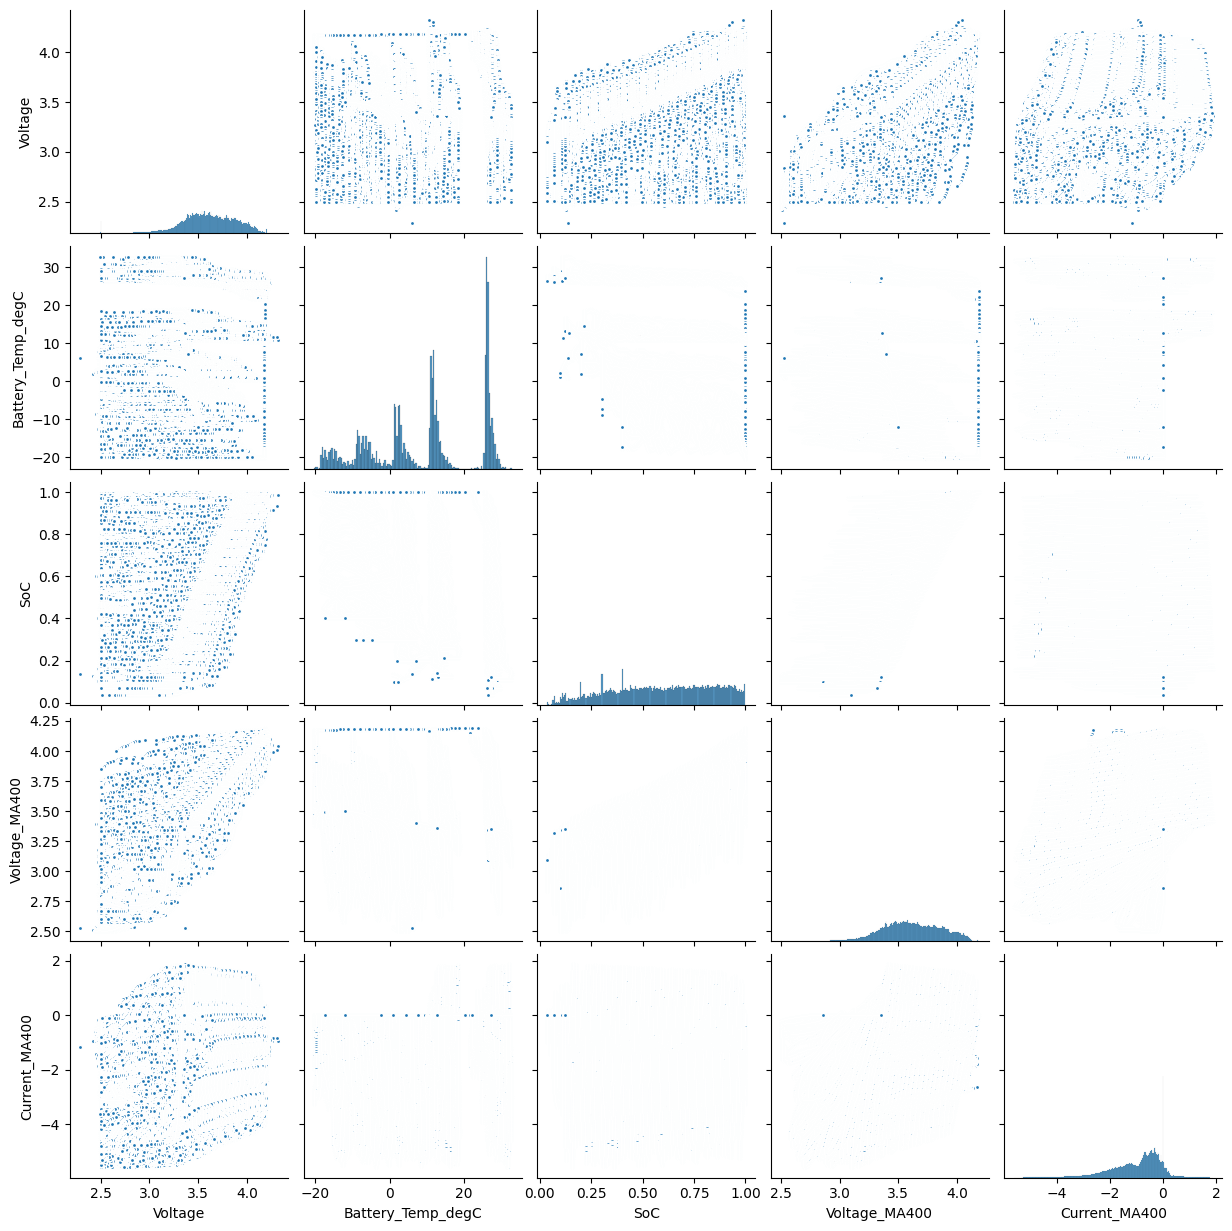

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, plot_kws=dict(marker=".", linewidth=1))

# Save file

In [17]:
df

,Voltage,Battery_Temp_degC,SoC,Voltage_MA400,Current_MA400
0,4.13620,0.335766,1.000000,4.136200,-1.797380e+00
1,4.06607,0.335766,0.999983,4.101135,-1.815755e+00
2,4.01782,0.335766,0.999966,4.073363,-1.832223e+00
3,3.98372,0.335766,0.999945,4.050953,-1.846378e+00
4,3.95863,0.335766,0.999928,4.032488,-1.858300e+00
...,...,...,...,...,...
116977,3.35336,27.480050,0.120821,3.352638,2.664535e-17
116978,3.35336,27.480050,0.120821,3.352642,2.664535e-17
116979,3.35336,27.480050,0.120821,3.352645,2.664535e-17
116980,3.35272,27.267100,0.120821,3.352646,2.664535e-17


In [19]:
df.to_csv("../data/data_panasonic_0.0.1.csv")

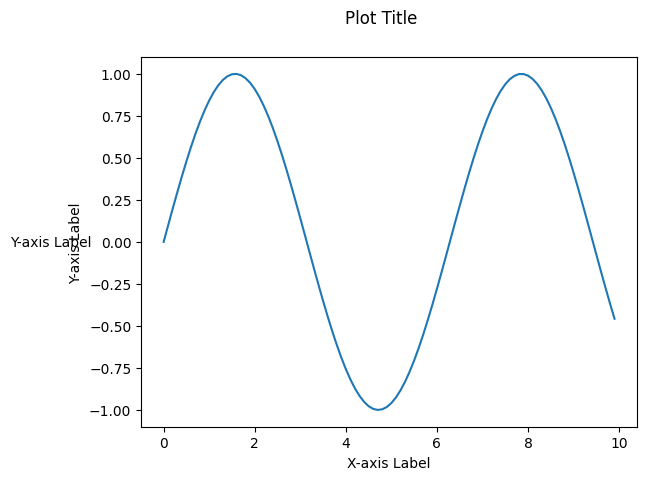

In [10]:

import matplotlib.pyplot as plt
import numpy as np

# create some sample data
x = np.arange(0, 10, 0.1)
y = np.sin(x)

# create a subplot
fig, ax = plt.subplots()

# plot the data on the subplot
ax.plot(x, y)

# add text to the left of the subplot
ax.text(-0.1, 0.5, "Y-axis Label", va='center', ha='right',
        rotation='horizontal', transform=ax.transAxes)

# set labels for the subplot
ax.set_xlabel("X-axis Label")
ax.set_ylabel("Y-axis Label")

# set title for the entire plot
fig.suptitle("Plot Title")

# show the plot
plt.show()